# NeRF Run Evaluation
Use this notebook to inspect artefacts produced by `models.train_nerf` or the smoke test.
1. Copy the desired `outputs/run_*` directory from the cluster to your local `outputs/` folder.
2. Run the cells below to view metrics, intermediate renders, checkpoints, and exported GIFs for the target and reconstructed views.

In [21]:
from pathlib import Path
import json
import sys
from IPython.display import display
from PIL import Image

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / 'outputs').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
assert (PROJECT_ROOT / 'outputs').exists(), 'Could not locate an outputs/ directory.\nPlease copy a run folder locally or adjust PROJECT_ROOT.'
sys.path.append(str(PROJECT_ROOT / 'src'))
print(f'Project root resolved to: {PROJECT_ROOT}')

available_runs = sorted((PROJECT_ROOT / 'outputs').glob('run_*'))
if available_runs:
    print('Available runs:')
    for run in available_runs:
        print(' -', run.relative_to(PROJECT_ROOT))
else:
    print('No run directories found under outputs/.')


Project root resolved to: /Users/brageramberg/Desktop/NeRF
Available runs:
 - outputs/run_900562


In [22]:
RUN_NAME = 'run_900562'  # update to the run you want to inspect
RUN_DIR = PROJECT_ROOT / 'outputs' / RUN_NAME
assert RUN_DIR.exists(), f'Run directory {RUN_DIR} not found'
figs_dir = RUN_DIR / 'figs'
metrics_path = RUN_DIR / 'logs' / 'metrics.json'
checkpoint_dir = RUN_DIR / 'ckpts'

metrics = json.loads(metrics_path.read_text())
metrics

{'psnr_per_view': [27.81601905822754,
  26.06747055053711,
  25.426786422729492,
  25.656539916992188,
  25.867816925048828,
  26.16119384765625,
  26.577571868896484,
  26.874025344848633,
  26.631649017333984,
  26.70553207397461,
  26.47127914428711,
  26.592817306518555,
  26.027164459228516,
  25.4929256439209,
  24.78527069091797,
  24.48244285583496,
  24.714275360107422,
  24.652673721313477,
  24.70685577392578,
  25.03082275390625,
  24.855688095092773,
  24.268569946289062,
  24.304397583007812,
  24.826313018798828,
  24.63747787475586,
  24.960323333740234,
  25.488231658935547,
  26.361759185791016,
  26.81451416015625,
  26.50325584411621,
  26.480308532714844,
  26.562435150146484,
  26.28702163696289,
  25.861927032470703,
  25.69583511352539,
  25.625333786010742,
  25.438528060913086,
  25.38478660583496,
  25.42984962463379,
  27.853681564331055],
 'psnr_mean': 25.75953426361084,
 'num_views_evaluated': 40}

intermediate_0000.png


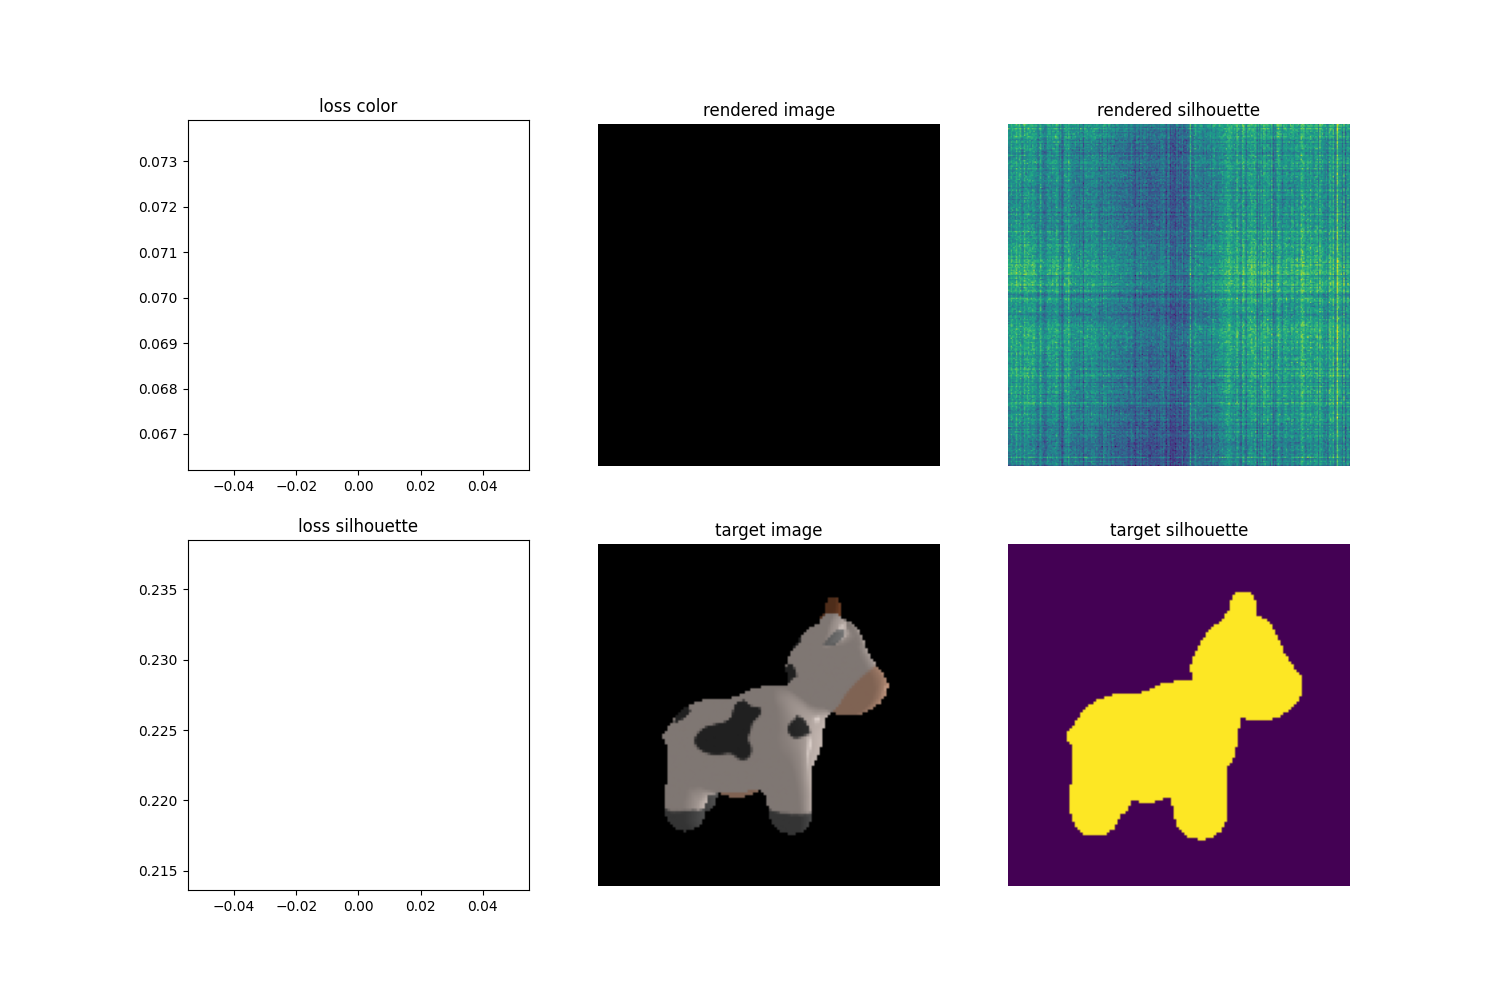

intermediate_0200.png


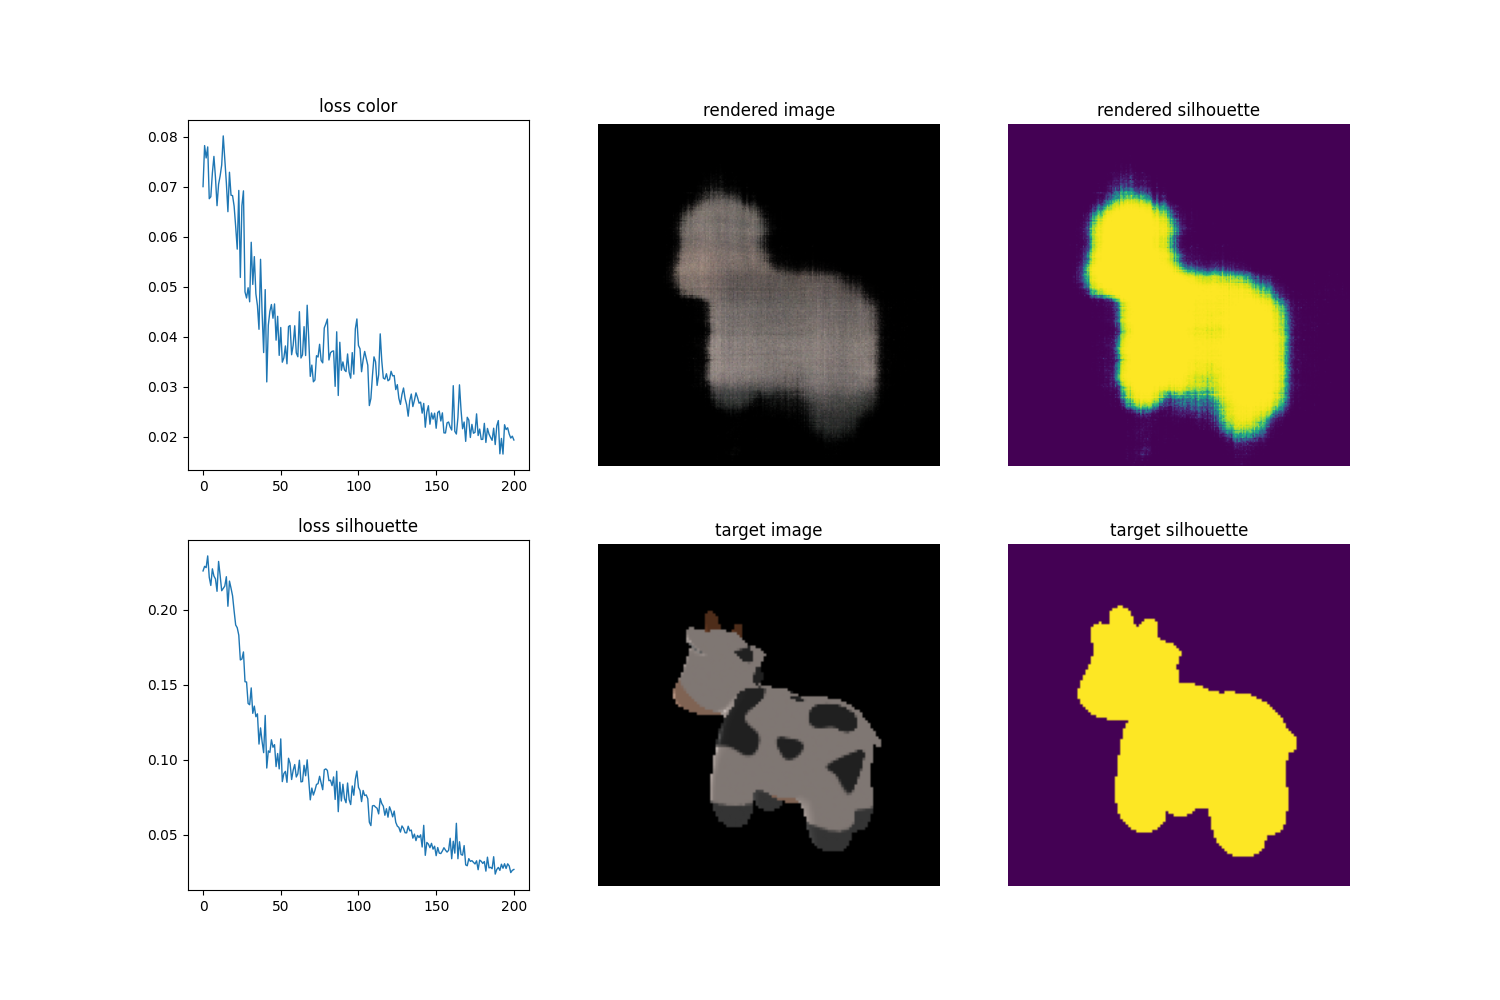

intermediate_0400.png


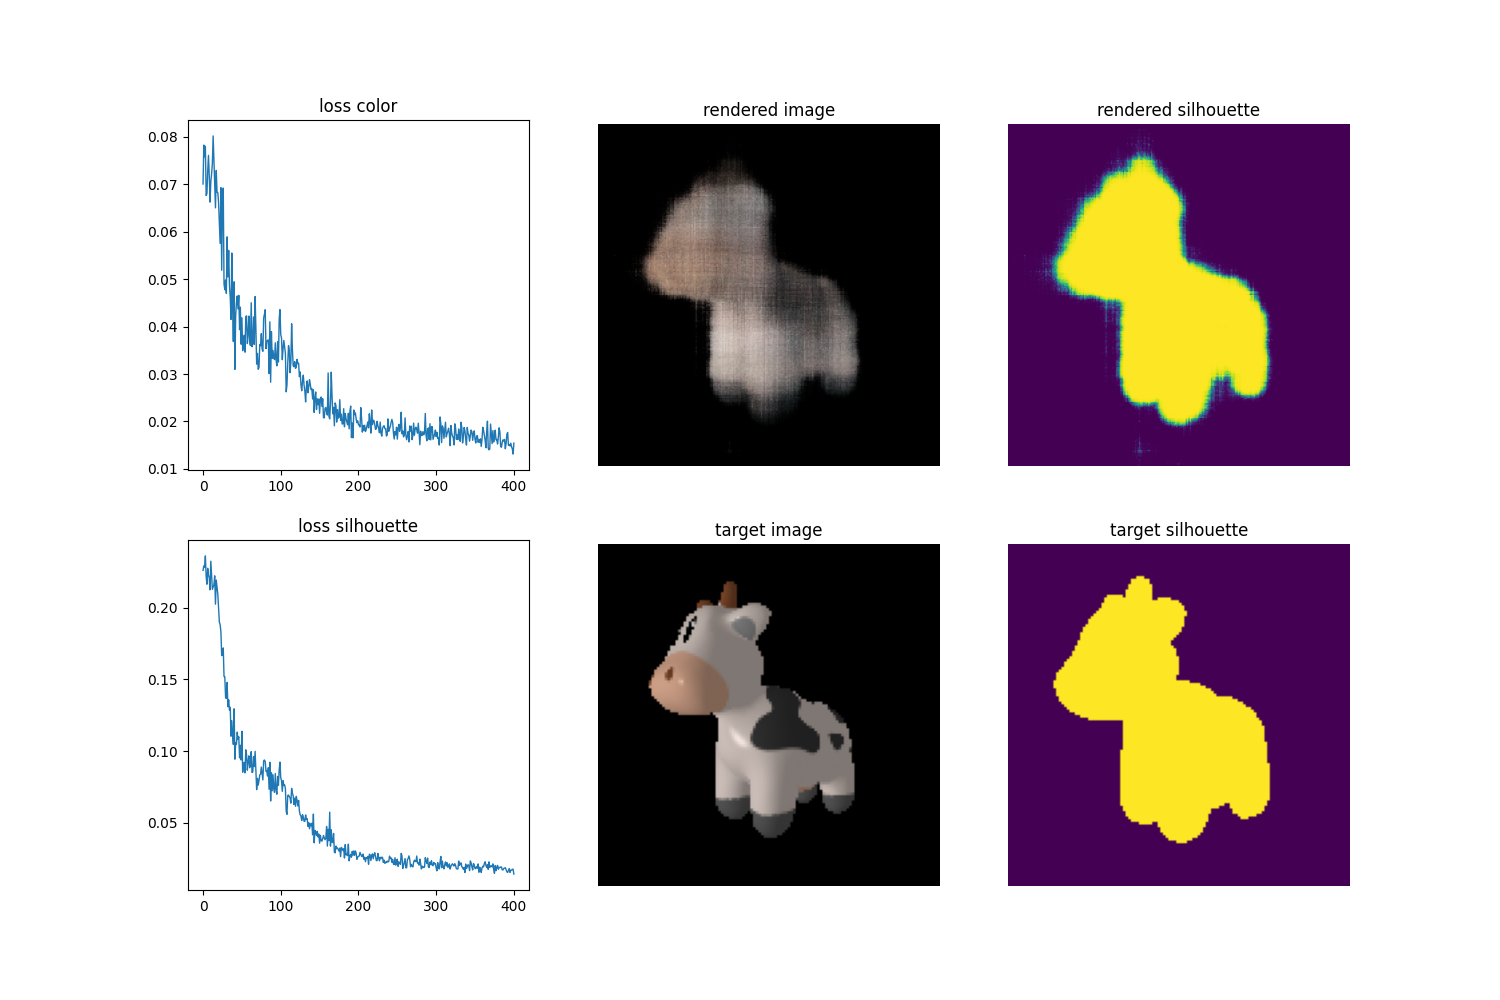

intermediate_0600.png


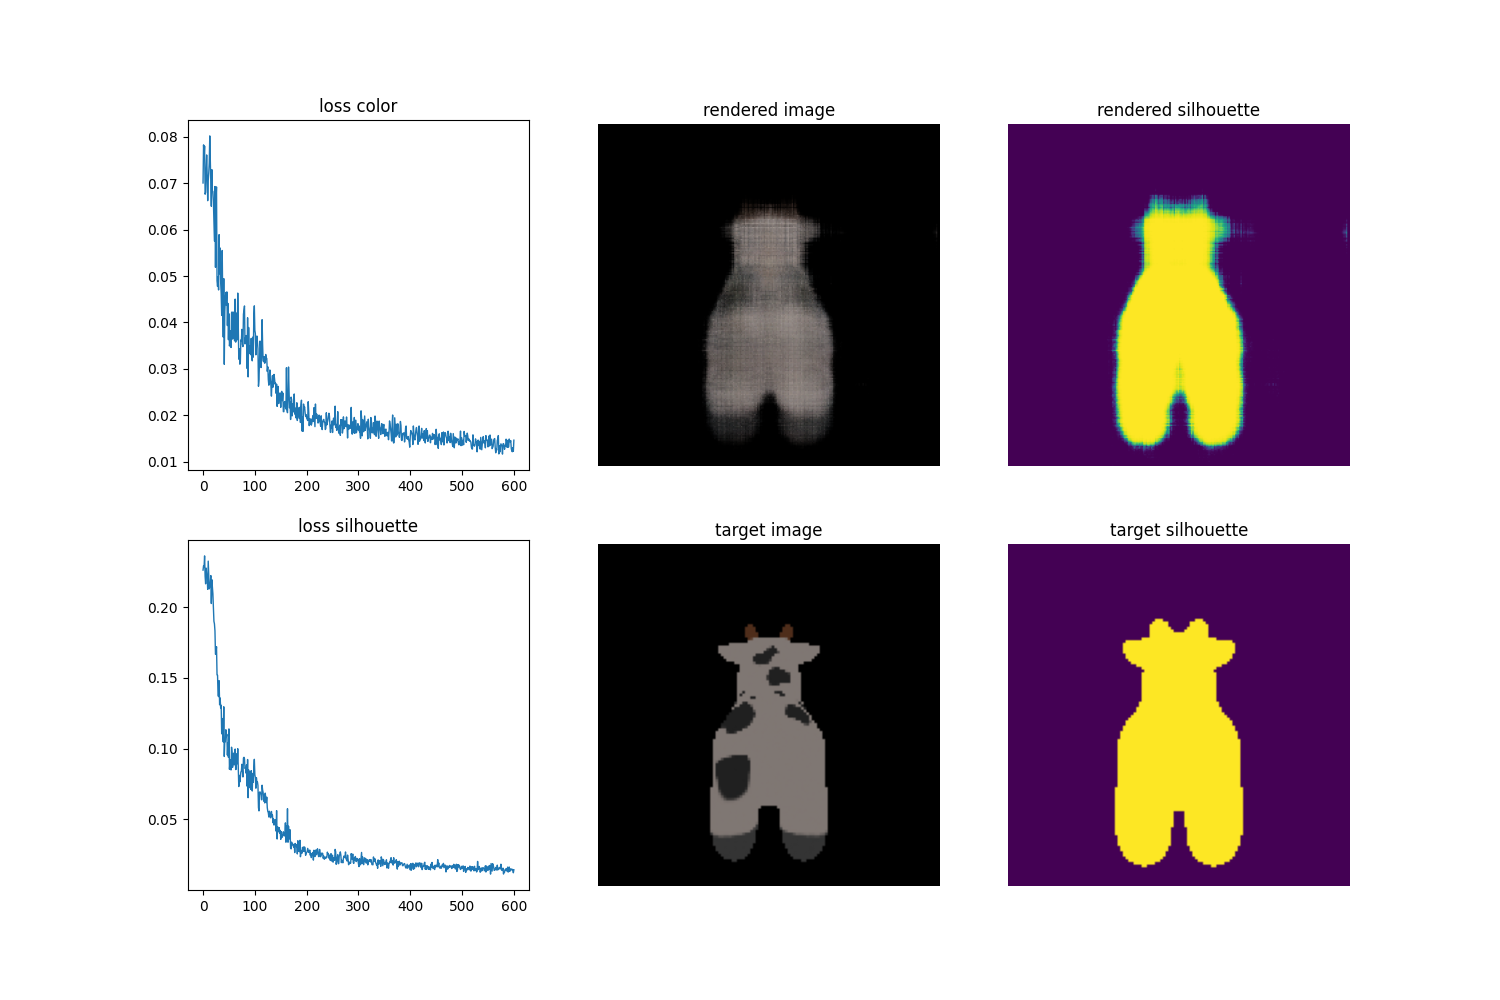

intermediate_0800.png


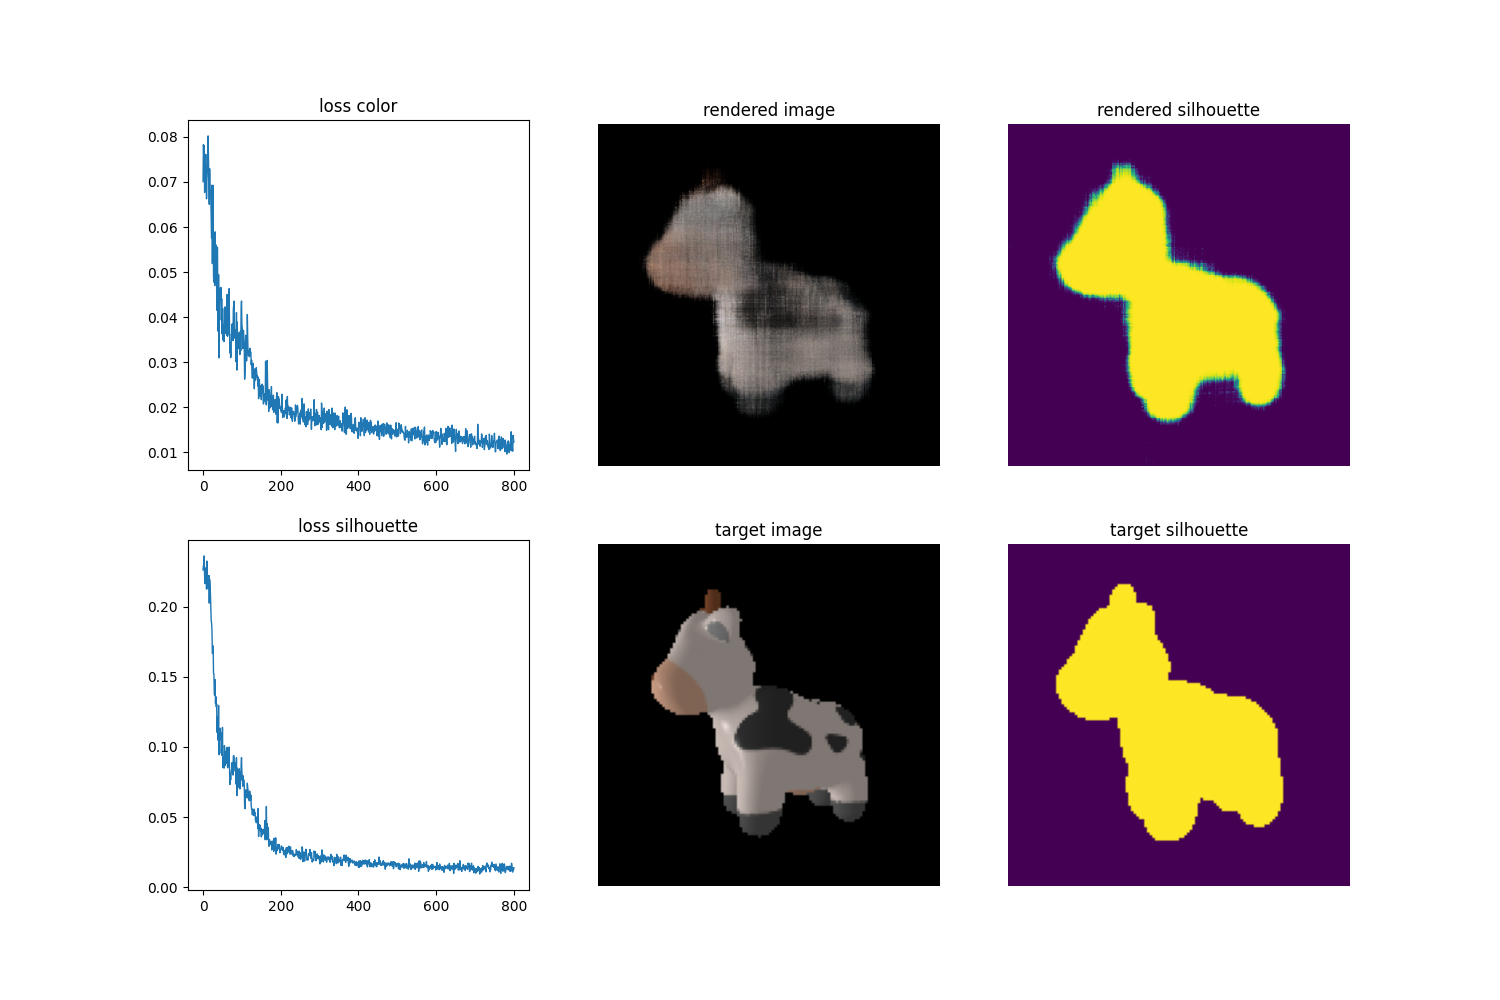

intermediate_1000.png


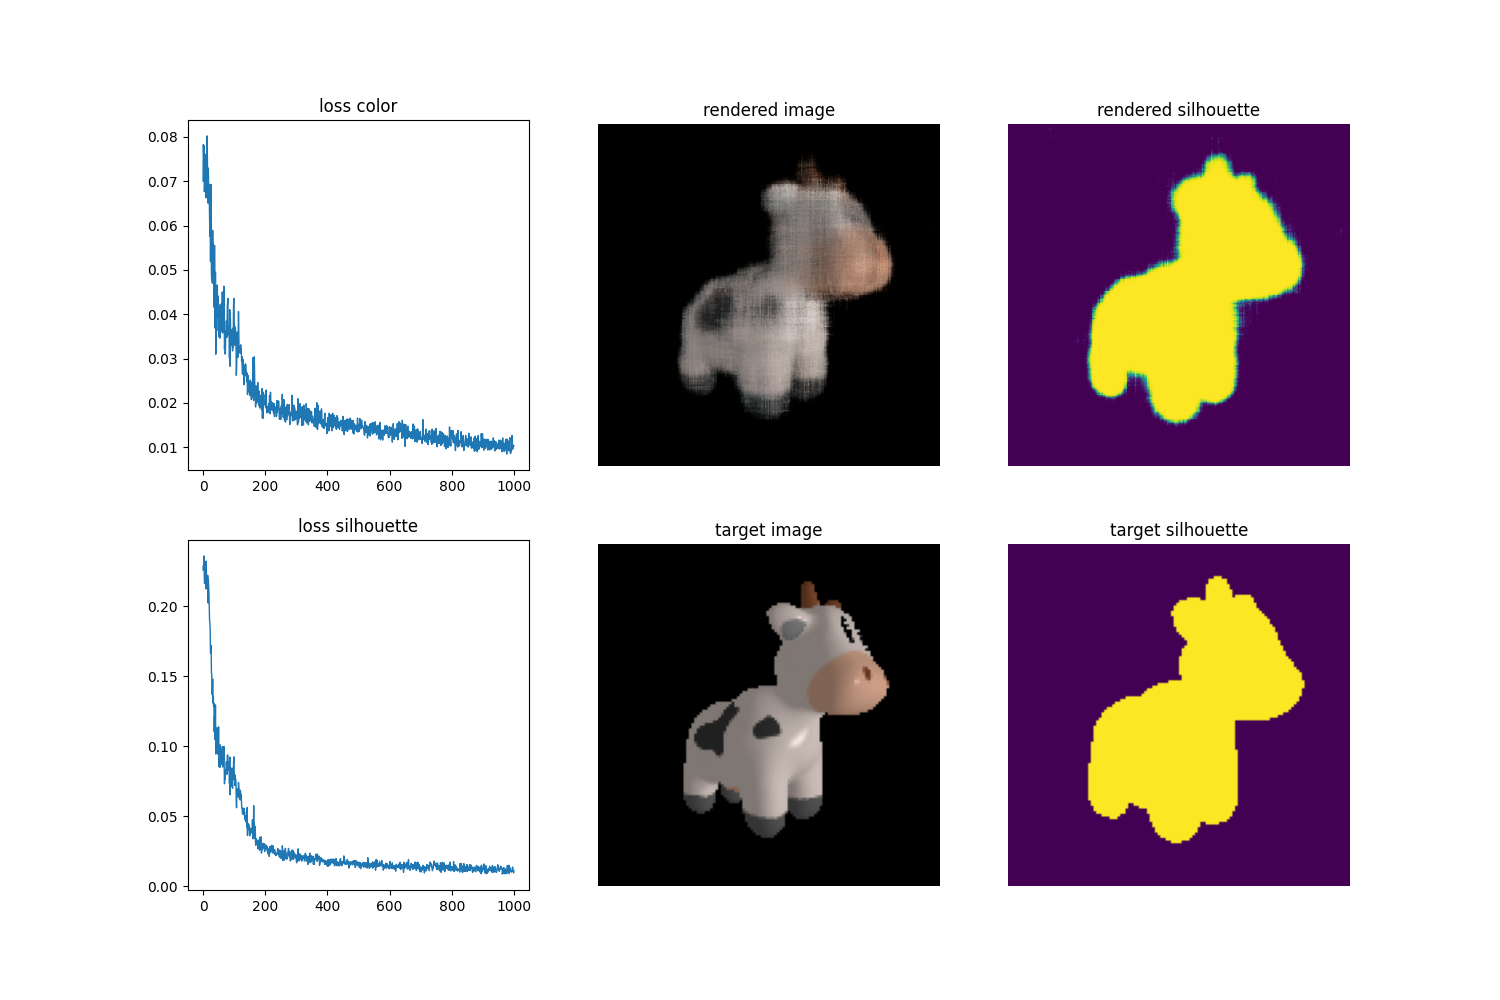

intermediate_1200.png


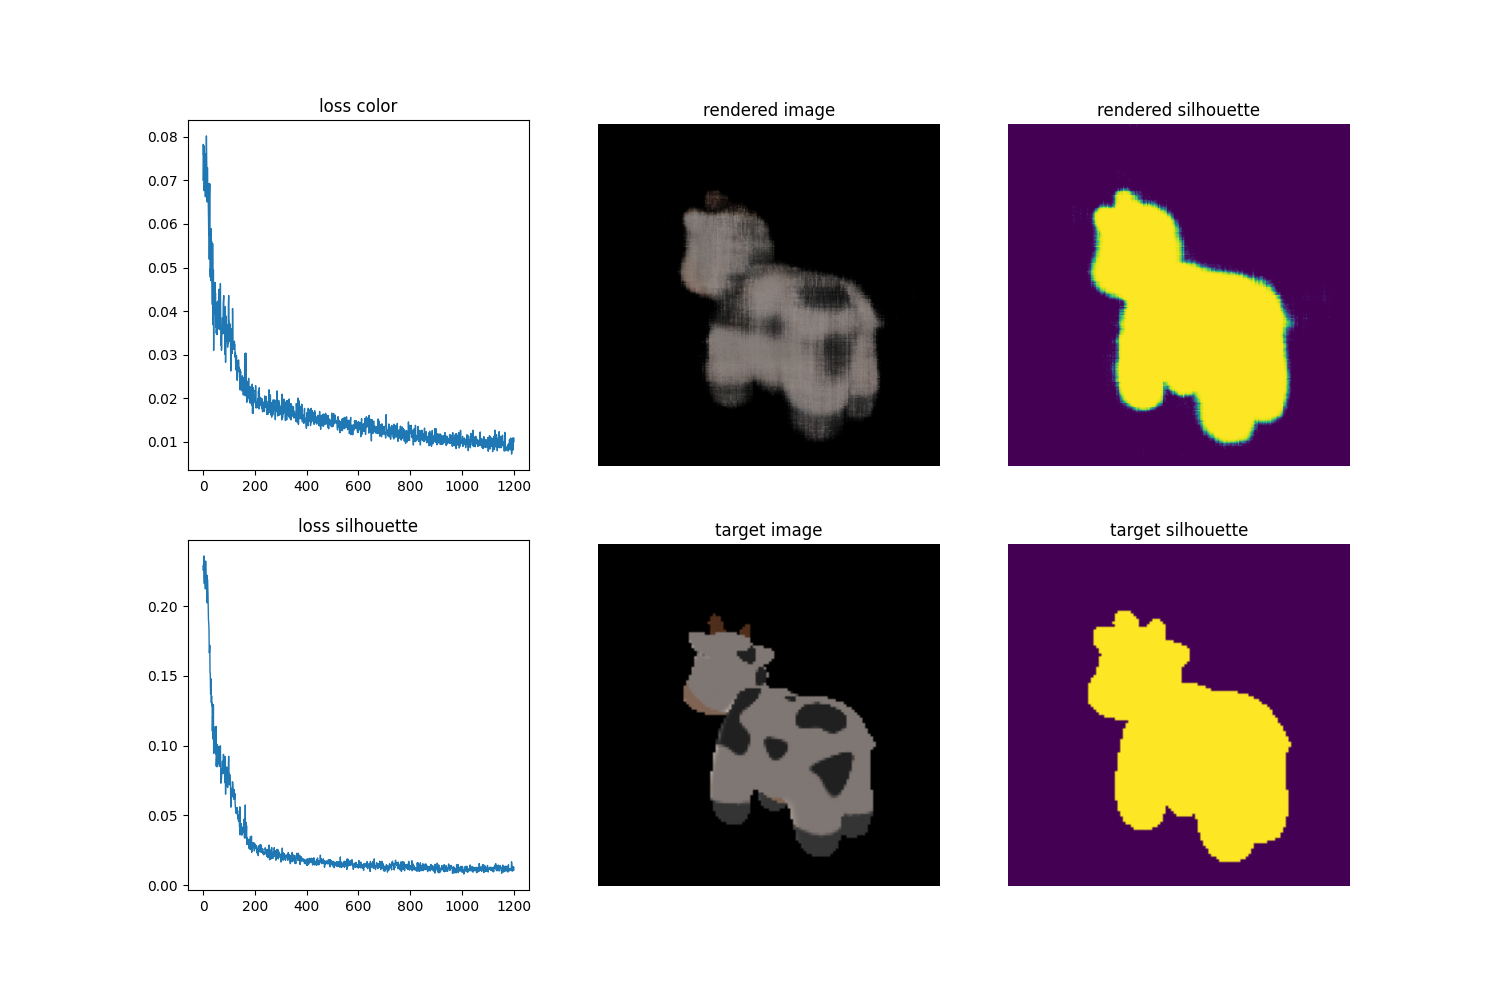

intermediate_1400.png


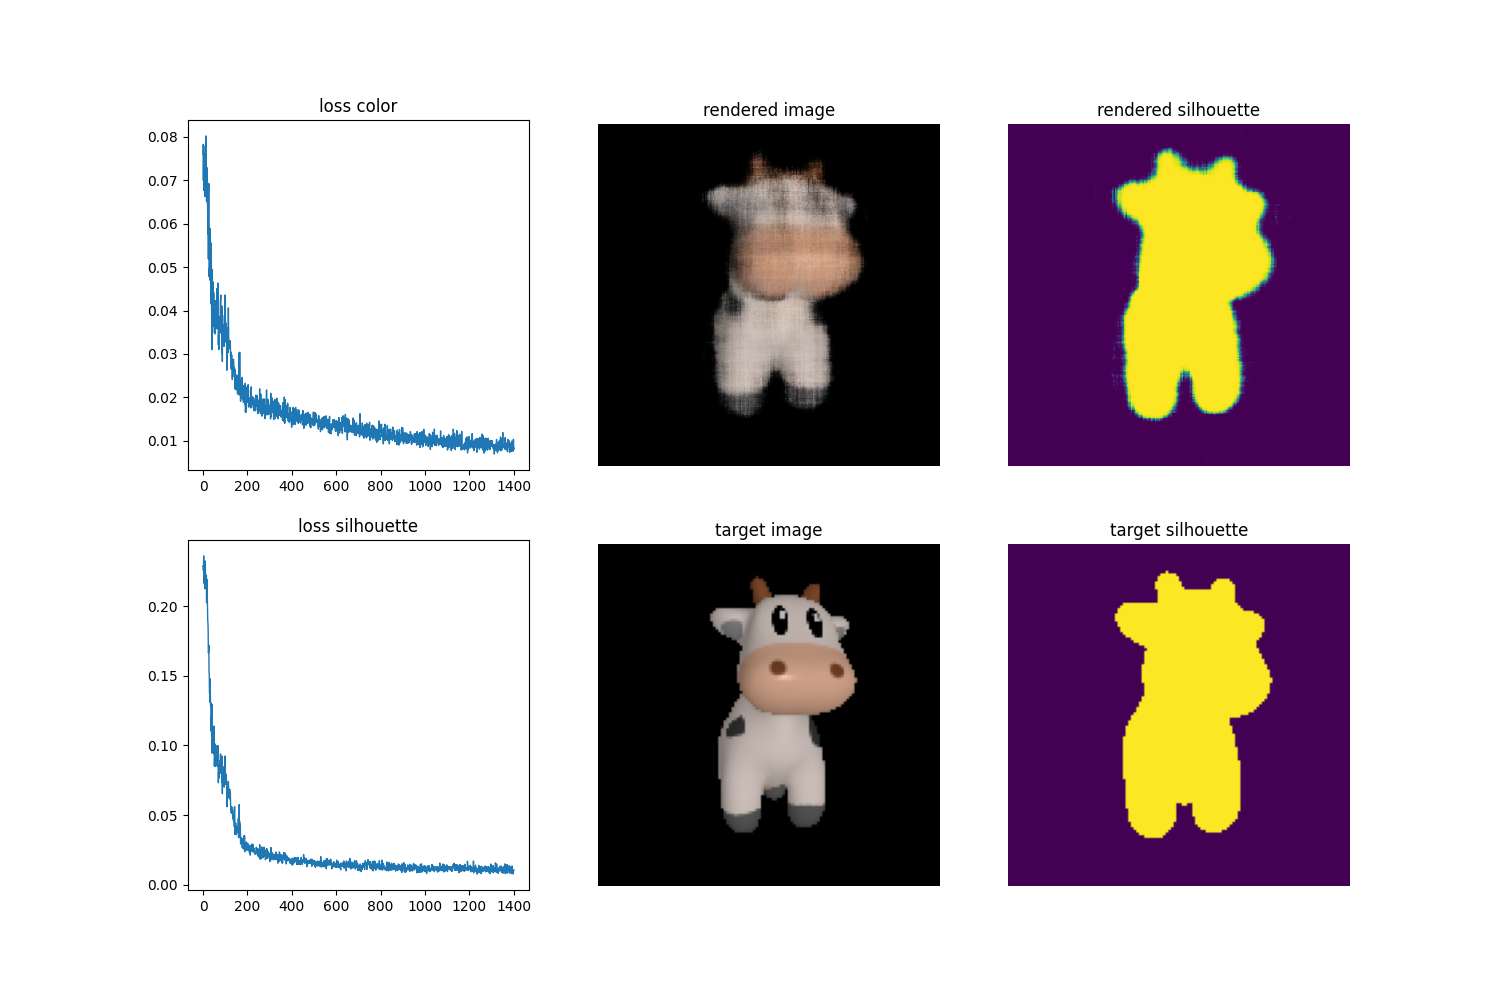

intermediate_1600.png


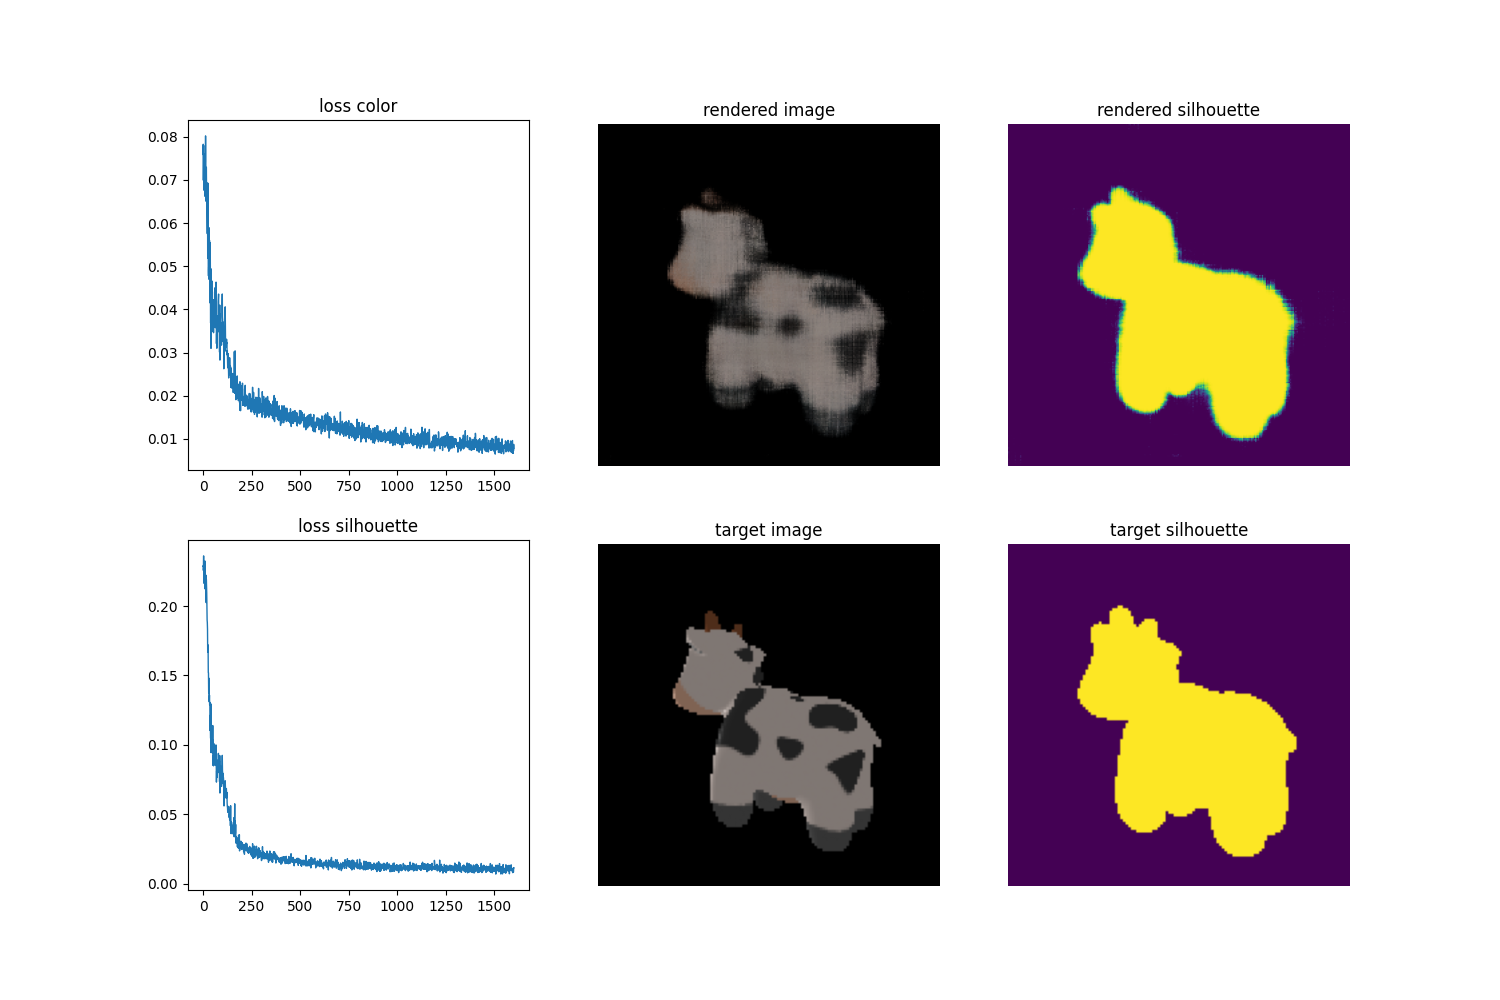

intermediate_1800.png


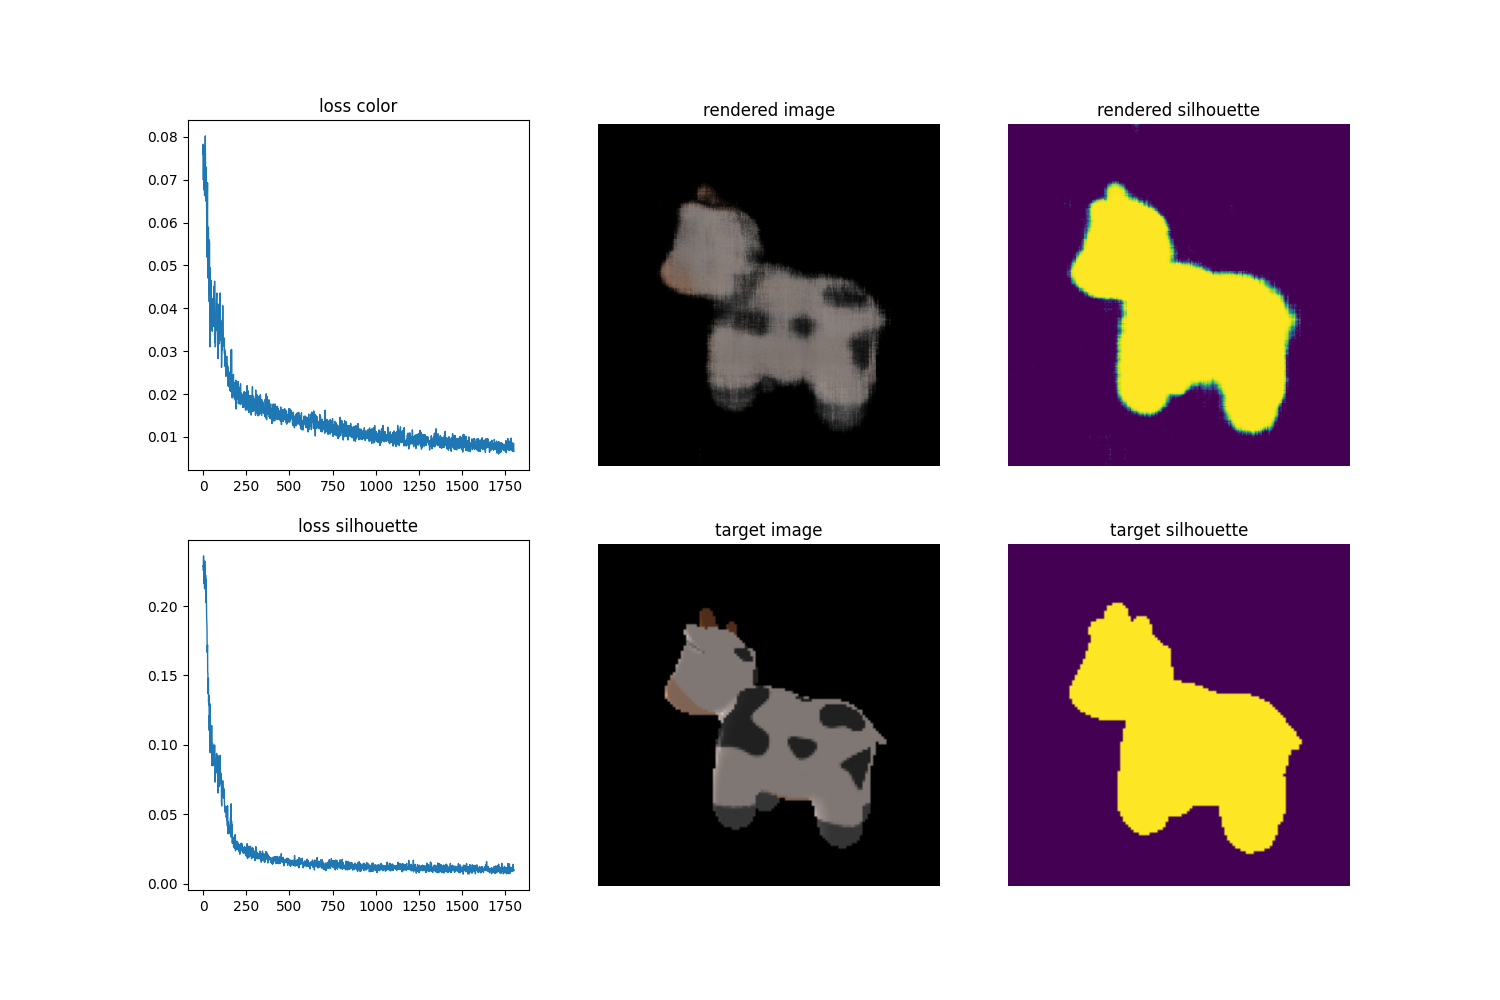

intermediate_2000.png


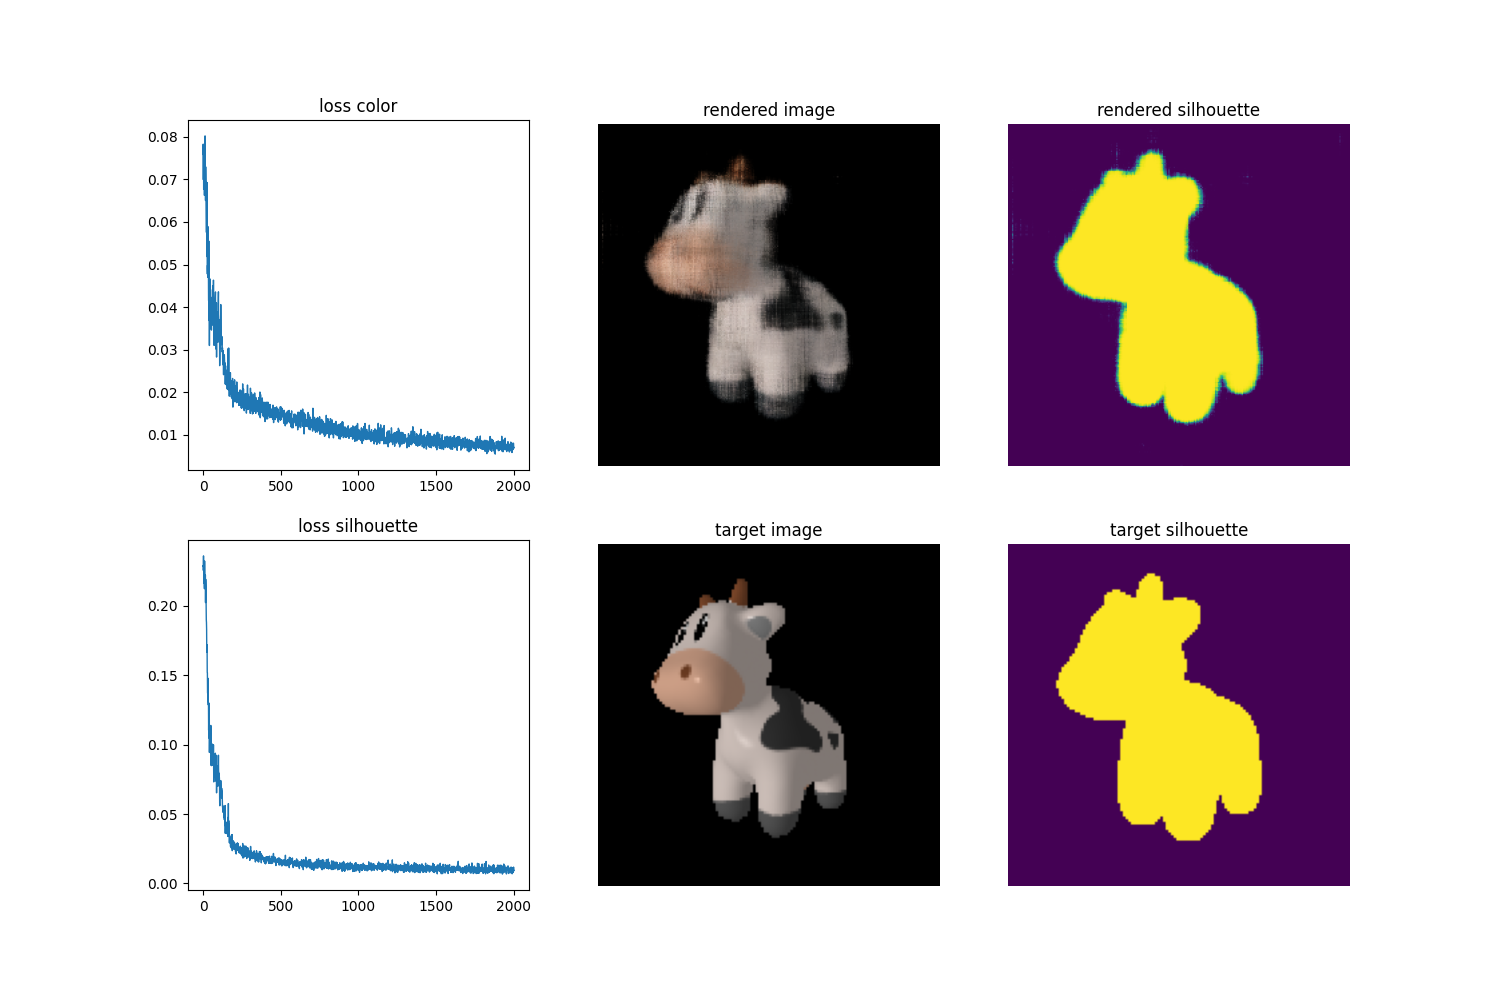

intermediate_2200.png


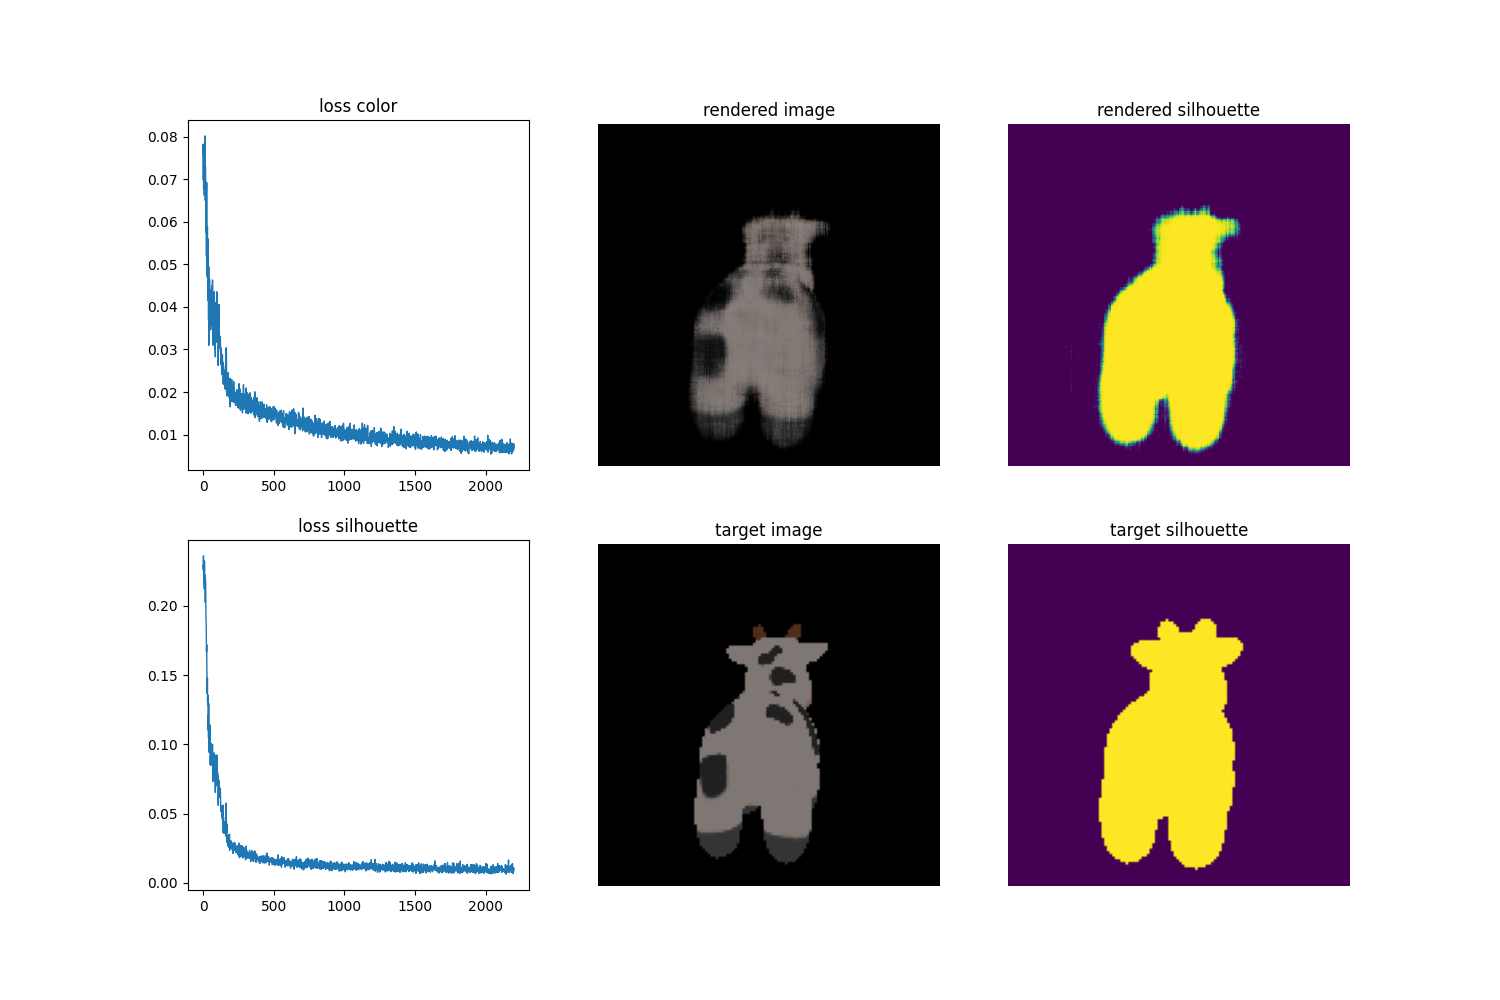

intermediate_2400.png


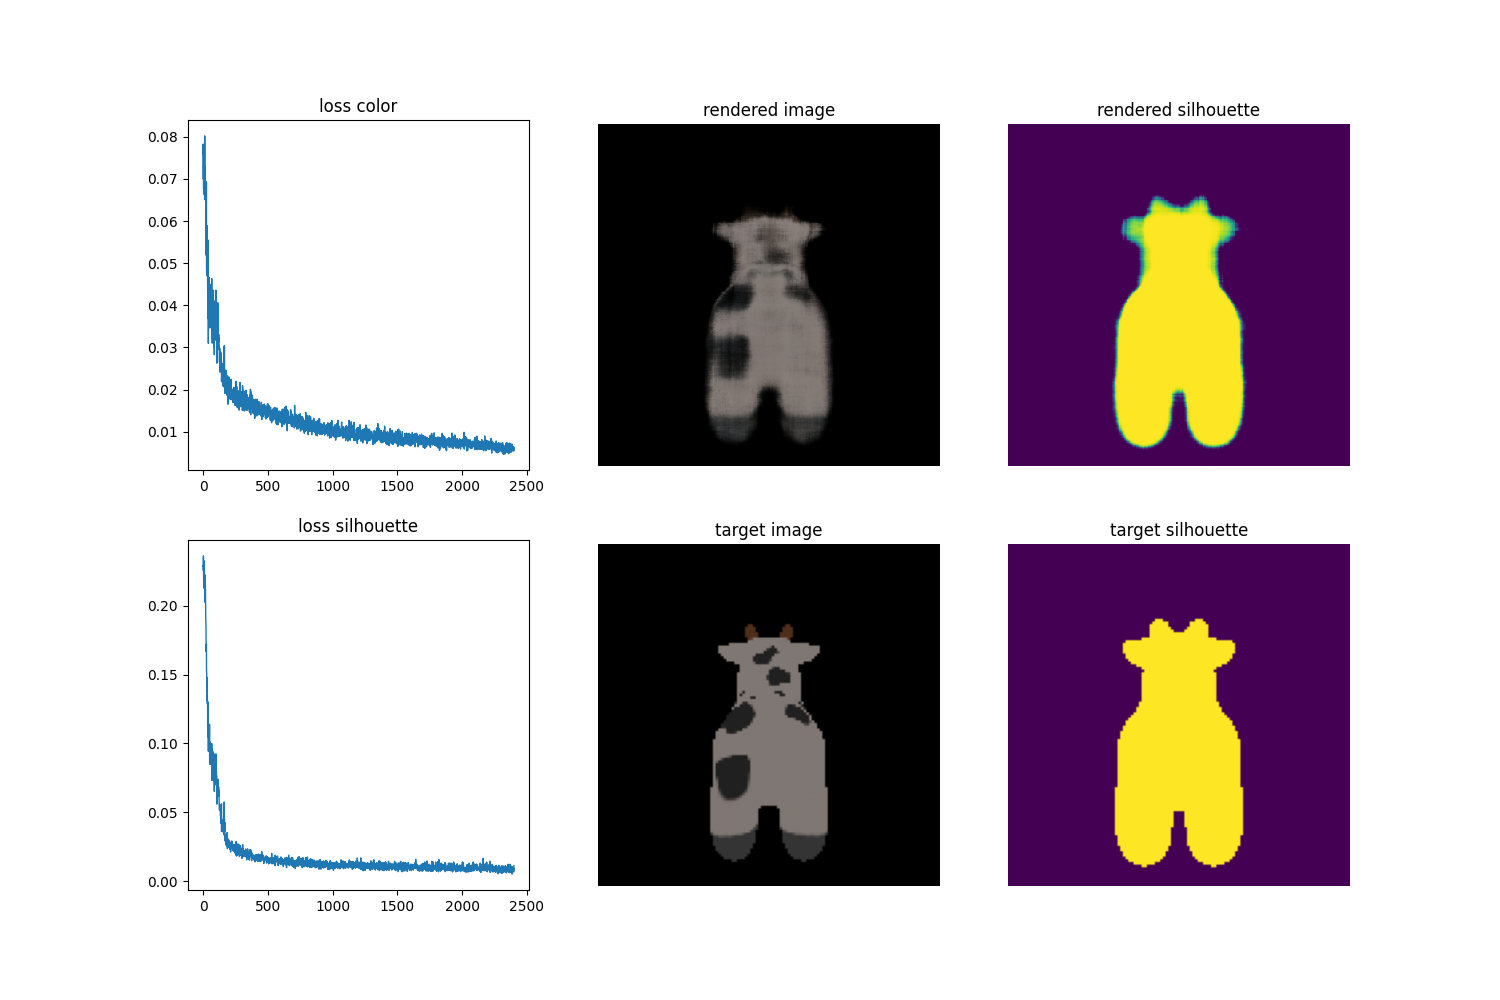

intermediate_2600.png


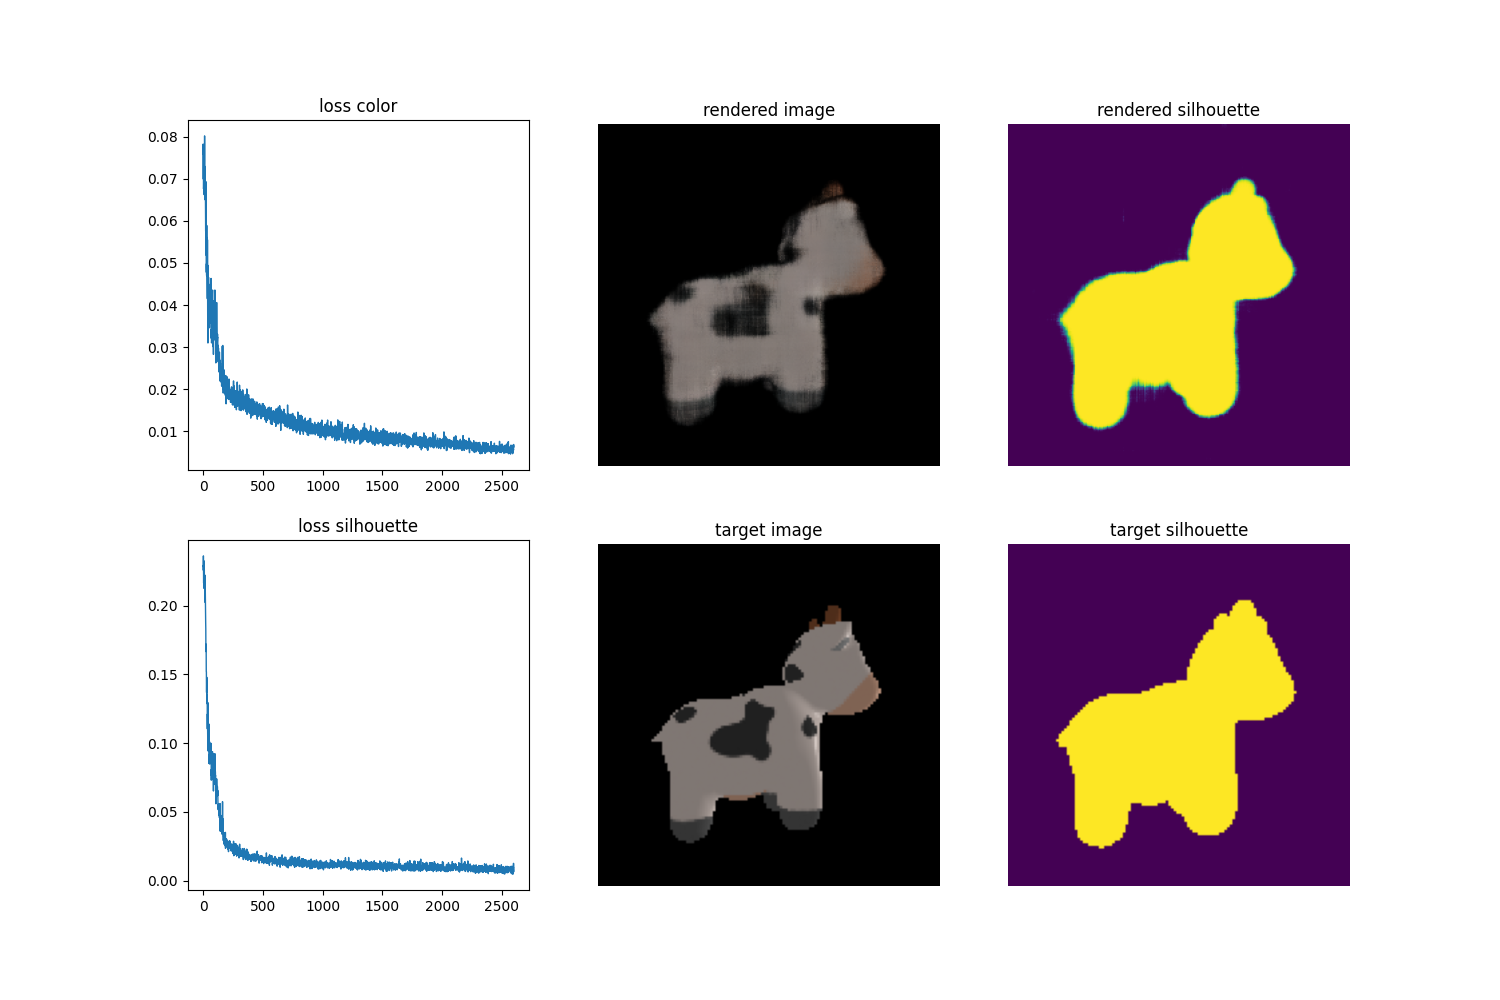

intermediate_2800.png


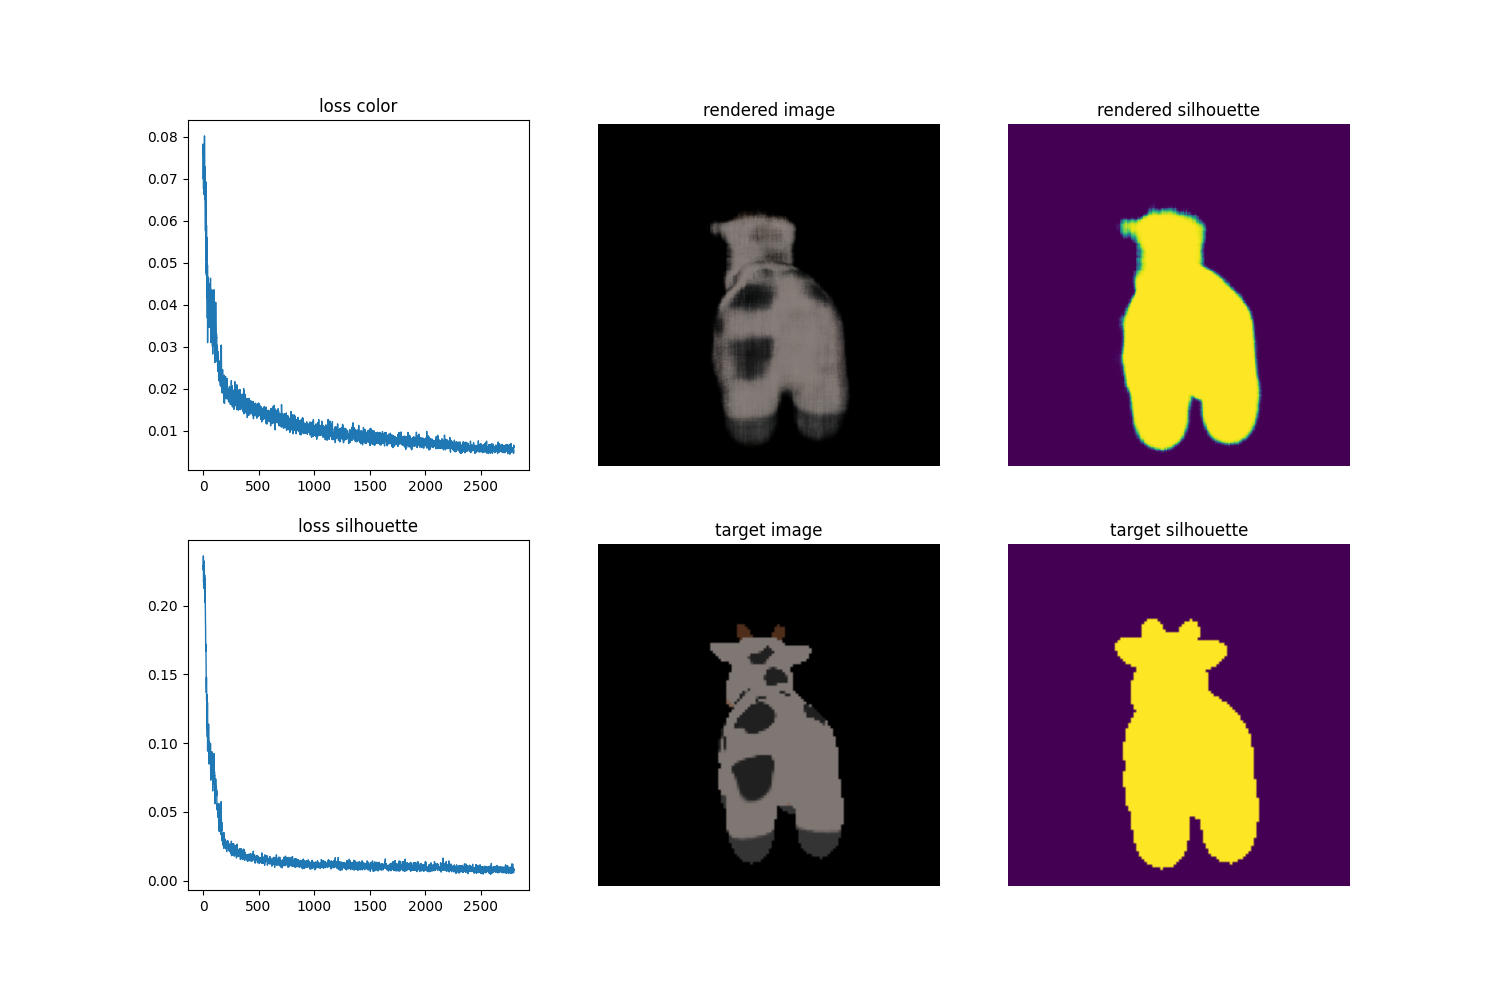

rotating_grid.png


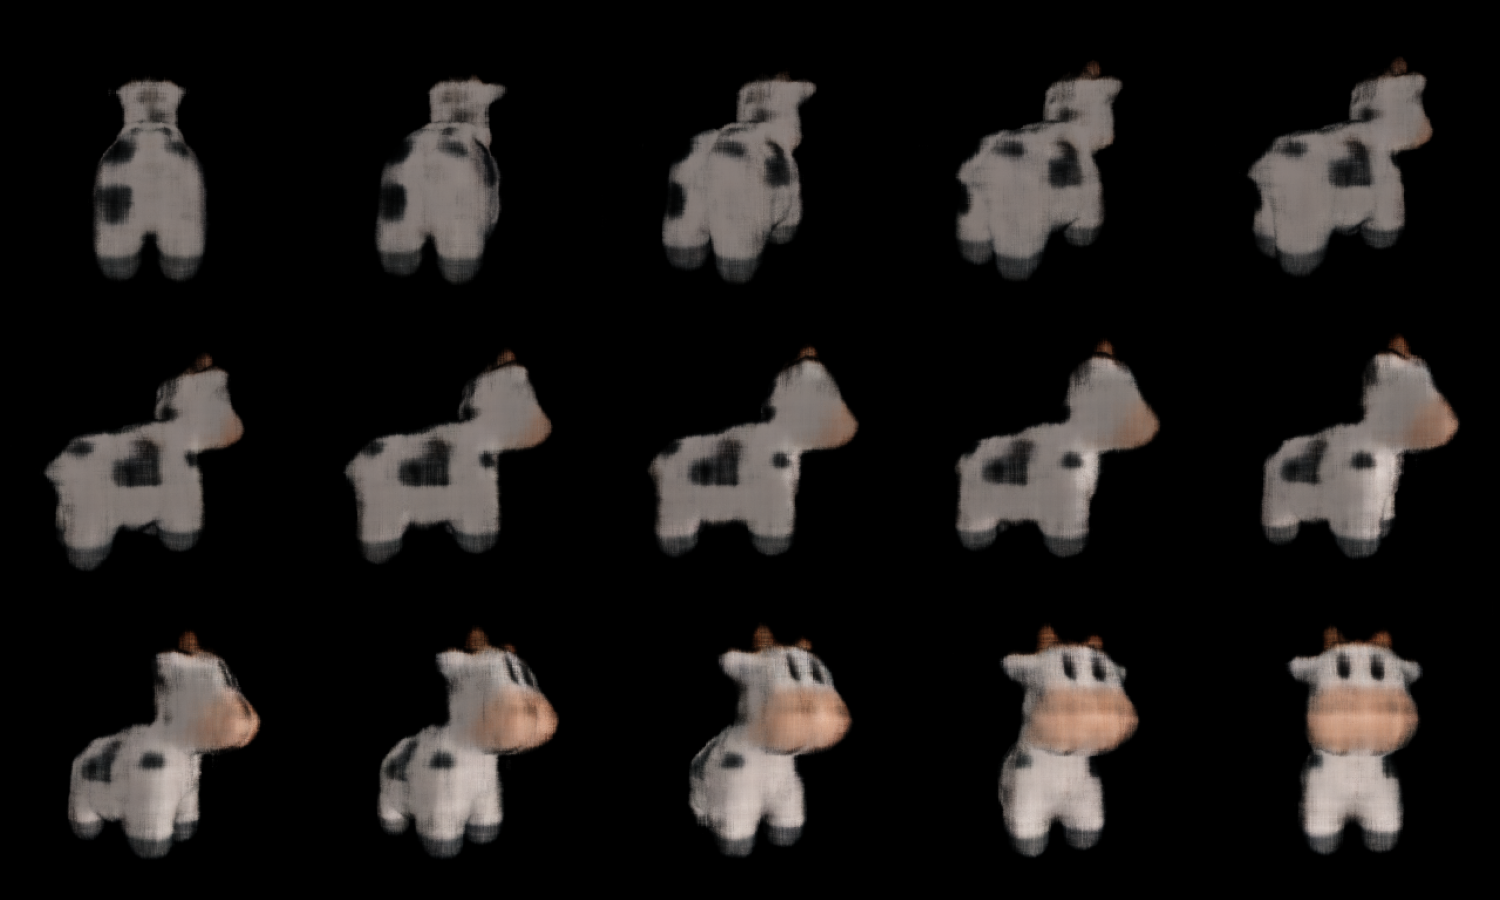

In [23]:
preview_images = sorted(figs_dir.glob('intermediate_*.png')) + [figs_dir / 'rotating_grid.png']
for image_path in preview_images:
    if image_path.exists():
        print(image_path.name)
        display(Image.open(image_path))


In [24]:
print('Available checkpoints:')
for ckpt in sorted(checkpoint_dir.glob('*.pth')):
    print(' -', ckpt.name)


Available checkpoints:
 - nerf_20251002-121510.pth


Rendering rotating NeRF ...


100%|██████████| 30/30 [08:12<00:00, 16.43s/it]


Saved predicted video to /Users/brageramberg/Desktop/NeRF/outputs/run_900562/figs/run_900562_pred.gif
Saved target video to /Users/brageramberg/Desktop/NeRF/outputs/run_900562/figs/run_900562_target.gif


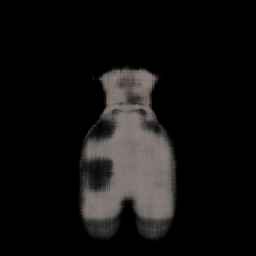

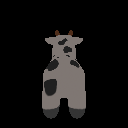

In [25]:
try:
    import imageio.v2 as imageio
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'imageio'])
    import imageio.v2 as imageio
import numpy as np
import torch
import pathlib
from torch.serialization import add_safe_globals

add_safe_globals([pathlib.PosixPath, pathlib.WindowsPath])

from models.nerf_model import NeuralRadianceField
from models.train_nerf import TrainConfig
from utils.generate_cow_renders import generate_cow_renders
from utils.helper_functions import generate_rotating_nerf
from pytorch3d.renderer import (
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    NDCMultinomialRaysampler,
)

ckpt_files = sorted(checkpoint_dir.glob('*.pth'))
assert ckpt_files, 'No checkpoints found to render videos.'
ckpt_path = ckpt_files[-1]
ckpt = torch.load(ckpt_path, map_location='cpu')
cfg_dict = ckpt['config']
cfg_dict['output_dir'] = Path(cfg_dict['output_dir'])
train_cfg = TrainConfig(**cfg_dict)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
target_cameras, target_images, _ = generate_cow_renders(
    num_views=train_cfg.num_views, azimuth_range=train_cfg.azimuth_range
)
render_size = target_images.shape[1] * 2
volume_extent_world = 3.0
raysampler_grid = NDCMultinomialRaysampler(
    image_height=render_size,
    image_width=render_size,
    n_pts_per_ray=train_cfg.n_pts_per_ray,
    min_depth=0.1,
    max_depth=volume_extent_world,
)
raymarcher = EmissionAbsorptionRaymarcher()
renderer_grid = ImplicitRenderer(raysampler=raysampler_grid, raymarcher=raymarcher)

renderer_grid = renderer_grid.to(device)
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)

nerf = NeuralRadianceField().to(device)
nerf.load_state_dict(ckpt['state_dict'])
nerf.eval()

with torch.no_grad():
    pred_frames = generate_rotating_nerf(
        nerf, target_cameras, renderer_grid,
        n_frames=train_cfg.rotating_frames, device=device
    ).cpu().numpy()

target_frames = target_images.cpu().numpy()
target_frames = target_frames[:pred_frames.shape[0]]

def to_uint8(frames: np.ndarray) -> np.ndarray:
    return (np.clip(frames, 0.0, 1.0) * 255).astype(np.uint8)

pred_gif = figs_dir / f'{RUN_NAME}_pred.gif'
target_gif = figs_dir / f'{RUN_NAME}_target.gif'
imageio.mimsave(pred_gif, to_uint8(pred_frames), duration=0.1, loop=0)
imageio.mimsave(target_gif, to_uint8(target_frames), duration=0.1, loop=0)

print(f'Saved predicted video to {pred_gif}')
print(f'Saved target video to {target_gif}')
display(Image.open(pred_gif))
display(Image.open(target_gif))
